[Last time,](DEN1_datasim.ipynb) we loaded data, saw that it was basically usable for simulation and then stored it.  

Now, we look a bit closer at the data and determine how to try to use it given the ml tools we'll try to apply.


In [1]:
# imports
import collections
import pandas as pd
import numpy as np
from scipy import stats

import sklearn
from sklearn import preprocessing as pp

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
import sys
import tensorflow as tf
import time
import os
import os.path
import pickle
import logging as log
log.basicConfig(level=log.DEBUG)


In [2]:
f = 'U.pkl'
P = pickle.load(open(f))
log.info('loaded <%s>',f)
P.describe()


INFO:root:loaded <U.pkl>


,Multiplier,Open,High,Low,Close,Volume,ADV,DeltaV,Return,Fwd_Close,Fwd_Return,SD,Fwd_Open,Fwd_COReturn
count,2724764,2724764.000000,2724764.000000,2724764.000000,2724764.000000,2.724764e+06,2.724763e+06,2724763.000000,2724763.000000,2724764.000000,2724764.000000,2724761.000000,2724764.000000,2724764.000000
mean,1,221.500822,223.113033,219.617956,221.458409,4.027689e+06,4.026459e+06,0.000170,0.000297,221.528037,0.000297,0.022109,221.569666,0.000316
std,0,4991.186437,5017.957331,4954.869489,4988.315556,1.211738e+07,1.086434e+07,0.478678,0.027592,4989.924149,0.027592,0.016716,4992.776936,0.014036
min,1,0.014558,0.078649,0.014558,0.058986,4.300000e+01,1.000000e+02,-9.486203,-3.570812,0.058986,-3.570812,0.000000,0.014558,-0.999744
25%,1,15.367480,15.611537,15.110396,15.369879,6.148695e+05,6.998400e+05,-0.277910,-0.010309,15.373677,-0.010309,0.012176,15.371148,-0.003635
50%,1,26.574552,26.946967,26.191651,26.577681,1.469000e+06,1.588625e+06,-0.011542,0.000225,26.584421,0.000225,0.017607,26.580746,0.000000
75%,1,45.038956,45.583092,44.483704,45.048963,3.604000e+06,3.718508e+06,0.261779,0.011050,45.060235,0.011050,0.026434,45.050000,0.004249
max,1,228180.000000,229374.000000,227530.000000,229300.000000,2.304019e+09,6.079510e+08,10.324815,1.449269,229300.000000,1.449269,0.812276,228180.000000,3.078370


INFO:root:ran over 4231 days and 2724764 rows in 111 secs


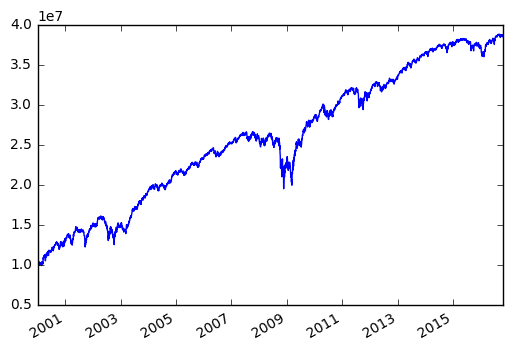

In [3]:
import sim
# can we still sim?

_,B = sim.sim(P)
# plot NAV
B.NAV.plot()


In [4]:
P.head()

,Sym,Product,Instrument,Multiplier,Expiry,Strike,Open,High,Low,Close,Volume,ADV,DeltaV,Return,Fwd_Close,Fwd_Return,SD,Fwd_Open,Fwd_COReturn
Date,,,,,,,,,,,,,,,,,,,
2000-01-03,A,A,STK,1,None,None,75.056373,75.237461,64.219662,68.622969,3343600,NaN,NaN,NaN,63.380937,-0.079464,NaN,64.934485,-0.053750
2000-01-03,PH,PH,STK,1,None,None,27.223018,27.223018,25.732145,25.896619,593400,2954703.30,-0.195882,0.007668,24.872639,-0.040344,0.009651,25.896619,0.000000
2000-01-03,KLAC,KLAC,STK,1,None,None,43.790268,43.790268,40.329959,42.327341,3769400,3275835.45,-0.517172,-0.009213,40.525016,-0.043514,0.012222,41.570521,-0.017880
2000-01-03,KMB,KMB,STK,1,None,None,39.020590,39.323075,38.185731,38.681807,1120200,2892712.10,0.009133,0.008792,38.343023,-0.008797,0.010058,38.379322,-0.007820
2000-01-03,ANF,ANF,STK,1,None,None,22.945486,23.001607,21.646685,22.047549,906100,808155.95,-0.398996,0.003940,20.796852,-0.058400,0.011808,22.199878,0.006909


Looks like it did yesterday.

Ok, now we want to use some portion of this data to train simple ml models.  

Let's define and run a function to normalize the data.


In [5]:
def prep_ml( u, show_plots=False  ) :
    # given universe, prep for ML: scale, center & generate moments
    t0 = time.time()
    log.info('scaling & centering...')

    u.reset_index( inplace=True)
    u.sort_values(['Sym','Date'],inplace=True)
    u.Date = pd.to_datetime(u.Date)
    u.set_index('Date',inplace=True)

    # scale & center prices & volume
    raw_scaled = u.groupby('Sym').transform( lambda x : (x - x.mean())/x.std())
    u = pd.concat([ u.Sym, raw_scaled], axis=1)

    # graphical sanity check
    if (show_plots):
        log.info('Plotting scaled & centered prices')
        fig, ax = plt.subplots()
        u.groupby('Sym')['Close'].plot(ax=ax)

    log.info('completed scaling & centering in %d...',(time.time()-t0))

    return u


INFO:root:scaling & centering...
INFO:root:Plotting scaled & centered prices
INFO:root:completed scaling & centering in 89...


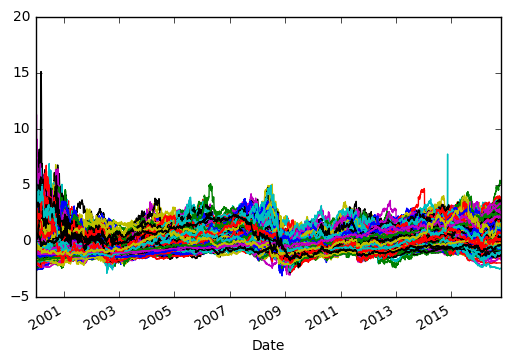

In [6]:
Z = prep_ml(P,show_plots=True)

In [7]:
Z.head()


,Sym,Multiplier,Expiry,Strike,Open,High,Low,Close,Volume,ADV,DeltaV,Return,Fwd_Close,Fwd_Return,SD,Fwd_Open,Fwd_COReturn
Date,,,,,,,,,,,,,,,,,
2000-01-03,A,NaN,NaN,NaN,2.861769,2.744996,2.200643,2.399139,0.245040,NaN,NaN,NaN,2.027664,-2.732842,NaN,2.142801,-3.566716
2000-01-04,A,NaN,NaN,NaN,2.140367,2.083297,2.015996,2.026013,0.283188,0.444965,0.046558,-2.732533,1.692322,-2.654520,NaN,2.014980,-0.217625
2000-01-05,A,NaN,NaN,NaN,2.012661,1.914254,1.774481,1.690879,0.700927,0.479809,0.452606,-2.654221,1.586425,-0.880411,NaN,1.700866,0.110413
2000-01-06,A,NaN,NaN,NaN,1.698831,1.630763,1.551219,1.585047,-0.654684,0.745800,-1.957777,-0.880321,1.925840,2.759631,-1.437982,1.526132,-1.015346
2000-01-07,A,NaN,NaN,NaN,1.524255,1.889917,1.612300,1.924252,-0.534776,0.259685,0.255138,2.759293,2.193299,2.029856,0.375577,2.201953,4.156967


Let's clean-out uninteresting columns

In [8]:
print Z.shape
Z.drop(['Multiplier','Expiry','Strike', 'Fwd_Open', 'Fwd_COReturn'],axis=1, inplace=True)
print Z.shape
Z.head()

(2724764, 17)
(2724764, 12)


,Sym,Open,High,Low,Close,Volume,ADV,DeltaV,Return,Fwd_Close,Fwd_Return,SD
Date,,,,,,,,,,,,
2000-01-03,A,2.861769,2.744996,2.200643,2.399139,0.245040,NaN,NaN,NaN,2.027664,-2.732842,NaN
2000-01-04,A,2.140367,2.083297,2.015996,2.026013,0.283188,0.444965,0.046558,-2.732533,1.692322,-2.654520,NaN
2000-01-05,A,2.012661,1.914254,1.774481,1.690879,0.700927,0.479809,0.452606,-2.654221,1.586425,-0.880411,NaN
2000-01-06,A,1.698831,1.630763,1.551219,1.585047,-0.654684,0.745800,-1.957777,-0.880321,1.925840,2.759631,-1.437982
2000-01-07,A,1.524255,1.889917,1.612300,1.924252,-0.534776,0.259685,0.255138,2.759293,2.193299,2.029856,0.375577


In [9]:
# let's get rid of NaNs from rolling windows
K = Z.dropna()
K.shape
K.head()

,Sym,Open,High,Low,Close,Volume,ADV,DeltaV,Return,Fwd_Close,Fwd_Return,SD
Date,,,,,,,,,,,,
2000-01-06,A,1.698831,1.630763,1.551219,1.585047,-0.654684,0.745800,-1.957777,-0.880321,1.925840,2.759631,-1.437982
2000-01-07,A,1.524255,1.889917,1.612300,1.924252,-0.534776,0.259685,0.255138,2.759293,2.193299,2.029856,0.375577
2000-01-10,A,2.199465,2.132628,2.213280,2.191545,-0.816972,0.011826,-0.648038,2.029603,2.129489,-0.469306,3.159755
2000-01-11,A,2.195389,2.087243,2.134647,2.127775,-0.939937,-0.239333,-0.348493,-0.469265,2.036489,-0.697395,3.173102
2000-01-12,A,2.131536,2.025414,1.967553,2.034833,-1.119094,-0.450823,-0.621716,-0.697327,2.104372,0.516390,2.677602


### data

The data is currently tainted with a few forward-looking values, all tagged Fwd_* they will need to be excised from the training set and perhaps used to create the 'labels' for classification purposes.  The data breaks down:

 - prices & moments: open, high, low, close; return, 20-day SD
 - volume, deltaV, 20-day ADV
 
Including the open, high, & low prices seem a bit heavy to me - a lot of parameters for limited information.  Perhaps we can represent them better.  One type of information we might hope to glean from them is the localized volatility.  This could be usefully transformed using Garman-Klass or something similar:

$$ \sigma = \sqrt{ \frac{Z}{n} \sum
  \left[ \textstyle\frac{1}{2}\displaystyle
    \left( \log \frac{H_i}{L_i} \right)^2  - (2\log 2-1)
    \left( \log \frac{C_i}{O_i} \right)^2 \right] }. $$

Z = Number of closing prices in a year, n = number of historical prices used for the volatility estimate.

For now, let's use the data as-is to establish a baseline and then see what else we can do.

###  model 
Let's see if a DNN says anything interesting. 

###  classes 
What classifications will we create?  

Let's see if the data advises otherwise, but it seems that we could break the universe of returns into five segments: 

 1. big down 
 2. small down 
 3. flat 
 4. small up
 5. big up

So, let's figure out what values should partition the classes and then convert our fwd-looking return to the labels and get rid of the fwd-looking values entirely.


[-0.5625479  -0.14485956  0.15176912  0.56808583]


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/p

Label
1    544942
2    544979
3    544917
4    544960
5    544963
dtype: int64


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Sym,Open,High,Low,Close,Volume,ADV,DeltaV,Return,SD,DOY,DOW,FSYM,VARATIO,Label
Date,,,,,,,,,,,,,,,
2000-01-06,A,1.698831,1.630763,1.551219,1.585047,-0.654684,0.745800,-1.957777,-0.880321,1.437982,6,3,0,0.877828,5
2000-01-07,A,1.524255,1.889917,1.612300,1.924252,-0.534776,0.259685,0.255138,2.759293,0.375577,7,4,0,2.059325,5
2000-01-10,A,2.199465,2.132628,2.213280,2.191545,-0.816972,0.011826,-0.648038,2.029603,3.159755,10,0,0,69.083658,2
2000-01-11,A,2.195389,2.087243,2.134647,2.127775,-0.939937,-0.239333,-0.348493,-0.469265,3.173102,11,1,0,3.927313,1
2000-01-12,A,2.131536,2.025414,1.967553,2.034833,-1.119094,-0.450823,-0.621716,-0.697327,2.677602,12,2,0,2.482335,4


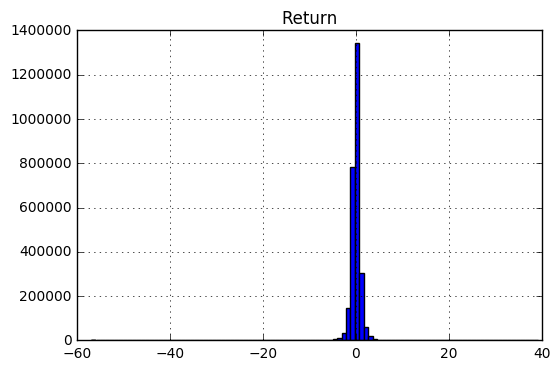

In [10]:
# first a quick look at the distribution of returns.
K.hist('Return',bins=100)

# now, where do we partition our classes?
q = K.Return.quantile([.2,.4,.6,.8]).values

print q

# let's add-in a 1-day Garman-Klass vol 
#K['GK'] = np.sqrt(np.abs( 252 * ( (1/2) * (np.log( K.High/ K.Low) )**2 - (2 *  np.log(2) - 1 ) * (np.log(K.Close/K.Open))**2 )))
K['SD'] = np.abs(K.SD)
#K['VOLARATIO'] = np.divide( K.GK , K.SD )


# let's classify date by doy and day of week
K['DOY'] = K.index.dayofyear
K['DOW'] = K.index.dayofweek

# let's encode the symbols
K['FSYM'], _ = pd.factorize(K.Sym)

# let's represent vol as ratio with ADV
K['VARATIO'] = np.abs(np.divide( K.Volume , K.ADV))

# let's create column of labels based on these values
K['Label'] = np.where( K.Fwd_Return < q[0], 1, 
            np.where( K.Fwd_Return < q[1], 2, 
                np.where( K.Fwd_Return < q[2], 3, 
                    np.where( K.Fwd_Return < q[3], 4,  5))))

# let's make sure labels look reasonable
print K.groupby('Label').size()

# Now that we have labels, let's get rid of fwd-looking values
K.drop(['Fwd_Return', 'Fwd_Close'],axis=1, inplace=True)

K.head()

In [11]:
# do we hava NaNs in our data?
K[K.isnull().any(axis=1)]


,Sym,Open,High,Low,Close,Volume,ADV,DeltaV,Return,SD,DOY,DOW,FSYM,VARATIO,Label
Date,,,,,,,,,,,,,,,


### now the data has been scaled and centered and we have both raw data (ie, prices, volume) and calculated data (ie, returns, sd, gk)

Let's partition into training and validation sets (80/20) and try a few different ways of packaging the data...

For training, we'll use three different data sets:
 - raw only
 - calculated only
 - raw & calculated

We'll try to use the tfcontrib code to ease our ascent of the tensorflow learning curve.


In [12]:
# we'll set our testing/validation divide 
TVDIVDATE = '2013-01-01'

# let's define which cols go where
RAW_COLS   = ['Close','Volume']  #'FSYM', 'Open','High','Low','DOY','DOW',
CALCD_COLS = ['ADV', 'DeltaV', 'Return', 'SD',  'VARATIO' ]# 'GK', 'VOLARATIO',
RAWNCALCD_COLS = RAW_COLS + CALCD_COLS

Dataset = collections.namedtuple('Dataset', ['data', 'target'])

Ktrain = K[K.index<=TVDIVDATE].reset_index()
Kvlad = K[K.index>TVDIVDATE].reset_index()

# raw training/validations data sets
raw_train = Dataset(data=Ktrain[RAW_COLS],target=Ktrain.Label )
raw_vlad = Dataset(data=Kvlad[RAW_COLS],target=Kvlad.Label )

# calcd training/validations data sets
calcd_train = Dataset(data=Ktrain[CALCD_COLS],target=Ktrain.Label )
calcd_vlad = Dataset(data=Kvlad[CALCD_COLS],target=Kvlad.Label )

# raw+calcd training/validations data sets
rc_train = Dataset(data=Ktrain[RAWNCALCD_COLS],target=Ktrain.Label )
rc_vlad = Dataset(data=Kvlad[RAWNCALCD_COLS],target=Kvlad.Label )

print raw_train.data.tail()
print calcd_train.data.tail()
print rc_train.data.tail()


            Close    Volume
2109092 -0.959806 -0.672835
2109093 -0.968654 -0.103744
2109094 -0.968101  0.049189
2109095 -0.975290 -0.067662
2109096 -0.960359  0.017921
              ADV    DeltaV    Return        SD   VARATIO
2109092  0.465595 -4.329714 -0.122837  0.353044  1.445106
2109093  0.402810  2.562888 -0.249906  0.350433  0.257551
2109094  0.313062  0.372908  0.018669  0.486040  0.157123
2109095  0.294503 -0.279096 -0.203828  0.485450  0.229750
2109096  0.298469  0.207773  0.430598  0.481799  0.060043
            Close    Volume       ADV    DeltaV    Return        SD   VARATIO
2109092 -0.959806 -0.672835  0.465595 -4.329714 -0.122837  0.353044  1.445106
2109093 -0.968654 -0.103744  0.402810  2.562888 -0.249906  0.350433  0.257551
2109094 -0.968101  0.049189  0.313062  0.372908  0.018669  0.486040  0.157123
2109095 -0.975290 -0.067662  0.294503 -0.279096 -0.203828  0.485450  0.229750
2109096 -0.960359  0.017921  0.298469  0.207773  0.430598  0.481799  0.060043


### data is partitioned into training/validation sets across three feature sets

let's create a dnn for the raw set and see how it does


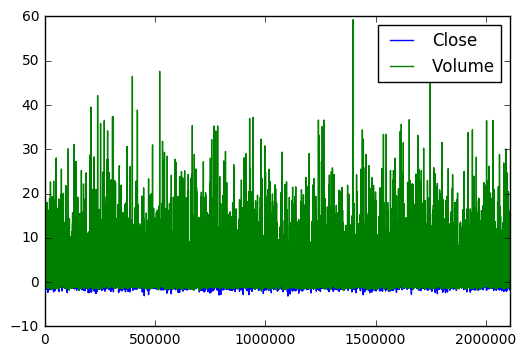

In [13]:
raw_train.data.plot()


In [14]:

def _fitntestdnn( train, vlad, layers=None, model_dir='/tmp/model', steps=100 ):
    # build network, train and validate
    fsize = len(train.data.columns)
    nclasses = len(train.target.unique())
    
    if layers is None:
        layers = [ fsize, fsize * 2, fsize]
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=fsize)]
    optimizer = tf.train.AdamOptimizer()

    # Build 3 layer DNN with fsize, 2*fsize, fsize layers
#    classifier = tf.contrib.learn.LinearClassifier(feature_columns=feature_columns,
#                                                n_classes=nclasses,
#                                                model_dir=model_dir)
    classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                                hidden_units=layers,
                                                n_classes=nclasses,
                                                optimizer=optimizer,
                                                model_dir=model_dir)

    # Fit model.
    classifier.fit(x=train.data, y=train.target, steps=steps)

    # Evaluate accuracy.
    accuracy_score = classifier.evaluate(x=vlad.data, y=vlad.target)["accuracy"]
    
    print('Accuracy: {0:f}'.format(accuracy_score))
    return accuracy_score


In [15]:
a = _fitntestdnn( train=rc_train, vlad=rc_vlad,model_dir='/tmp/rc')


Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
INFO:tensorflow:Using config: {'task': 0, 'save_summary_steps': 100, 'keep_checkpoint_max': 5, '_is_chief': True, 'save_checkpoints_secs': 600, 'evaluation_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'master': '', 'keep_checkpoint_every_n_hours': 10000, '_job_name': None, 'cluster_spec': None, 'tf_random_seed': None, 'num_ps_replicas': 0}
INFO:tensorflow:Using config: {'task': 0, 'save_summary_steps': 100, 'keep_checkpoint_max': 5, '_is_chief': True, 'save_checkpoints_secs': 600, 'evaluation_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'master': '', 'keep_checkpoint_every_n_hours': 10000, '_job_name': None, 'cluster_spec': None, 'tf_random_seed': None, 'num_ps_replicas': 0}
INFO:tensorflow:Setting feature info to TensorSignature(dtype=tf.flo

NanLossDuringTrainingError: NaN loss during training.